<a href="https://colab.research.google.com/github/lowbee2019/Algorithm/blob/master/MyModel-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install emnist

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import collections
import copy
import random
import emnist

# Server Initialization

In [9]:
class ParamServer(object):
  def __init__(self,init_model_path):
    self.init_model_path = init_model_path
    self.round = 0
    self.optimizer="adam"
    self.loss = "sparse_categorical_crossentropy"
    self.metrics =['accuracy']

  def PreTrain(self,model,data,labels,batch_size=32,epochs=5):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    _metrics = model.fit(data,labels,batch_size,epochs)
    return model
  
  def PreEval(self,model,test_data,test_labels):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    model.evaluate(test_data,test_labels)


## Mnist数据集的预处理

In [10]:
mnist = tf.keras.datasets.mnist
train,test = mnist.load_data()
x_train,y_train = train
x_test,y_test = test
x_train,x_test = x_train/255.0,x_test/255.0

In [11]:
x_train.shape

(60000, 28, 28)

## 模型的定义

In [12]:
class FLModel(tf.keras.Model):
  def __init__(self,row,col,num_classes=62,*args,**kwargs):
    super(FLModel,self).__init__(*args,**kwargs)
    self.row = row
    self.col = col
    self.num_classes = num_classes
    self.flatten = tf.keras.layers.Flatten(input_shape=(row,col))
    self.dense_1 = tf.keras.layers.Dense(128,activation='relu',name="dense_1")
    self.dense_2 = tf.keras.layers.Dense(num_classes,activation='softmax',name="dense_2")
    self.drop = tf.keras.layers.Dropout(0.2)


  def call(self,inputs):
    x = self.flatten(inputs)
    x = self.dense_1(x)
    x = self.drop(x)
    x = self.dense_2(x)
    return x
  
  def copy(self):
    NewModel = FLModel(self.row,self.col,self.num_classes)
    _ = NewModel(np.expand_dims(tf.zeros([self.row,self.col]),0))
    ##Layers
    NewVars = NewModel.trainable_variables #此处为空列表，因为没有训练,这个地方参数传递是不是有问题
    OldVars = self.trainable_variables
    for n,o in zip(NewVars,OldVars):
      n.assign(o.numpy())
    return NewModel

  # def compute_output_shape(self,input_shape):
  #   shape = tf.TensorShape(input_shape).as_list()
  #   shape[-1] = self.num_classes
  #   return tf.TensorShape(shape)

#Client Initialization
模型训练和评估都要重写

In [13]:
class Client(object):
  def __init__(self,id,model=None,Train_dataset=None,Test_dataset=None):
    self.id = id
    self.model = model
    self.Train_dataset = Train_dataset
    self.Test_dataset = Test_dataset
    # from ParamServer
    self.ParamModel = None
    self.num_epochs = 5
    self.batch_size = 32
    self.shuffle_buffer = 100
    self.prefetch_buffer = 10


  def ReceiveModel(self,ParamModel,num_epochs=1,batch_size=32,shuffle_buffer=100,prefetch_buffer=10):
    self.ParamModel = ParamModel
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.shuffle_buffer = shuffle_buffer
    self.prefetch_buffer = prefetch_buffer
  

  def preprocess(self,dataset):
    def batch_format_fn(element):
      return collections.OrderedDict(
            
            x = tf.reshape(element['pixels'],[-1,784]),
            y = tf.reshape(element['label'],[-1,1])
          )
    return dataset.repeat(self.num_epochs).shuffle(self.shuffle_buffer).batch(
        self.batch_size).map(batch_format_fn).prefetch(self.prefetch_buffer)

  def NodeTrain(self):
    model = self.ParamModel
    # pre_data = self.preprocess(self.Train_dataset)
    # print(type(pre_data))
    # model.fit(x=pre_data['x'],y=pre_data['y'],batch_size=self.batch_size,epochs=self.num_epochs)
    # x = np.array([i['pixels'].numpy() for i in self.Train_dataset])
    # y = np.array([i['label'].numpy() for i in self.Train_dataset])
    x,y = self.Train_dataset
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    _metrics = model.fit(x,y,batch_size=self.batch_size,epochs=self.num_epochs)
    self.model = model

  def NodeEval(self):
    x,y = self.Test_dataset
    self.model.evaluate(x,y)


#阶段一：服务器完成模型初始化

In [108]:
InitModel = FLModel(row=28,col=28,num_classes=62)
S = ParamServer("")

In [109]:
S.PreEval(InitModel,x_test,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 4.0848 - accuracy: 0.0231


In [110]:
SendModel = S.PreTrain(InitModel,x_train[0:3000],y_train[0:3000],epochs=1)
S.PreEval(SendModel,x_test,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.5909 - accuracy: 0.8304


In [17]:
#x_test.shape

# 阶段二：为Client分配数据（预处理工作）

In [18]:
emnist_dataset = emnist.extract_training_samples('byclass')

In [19]:
emnist_dataset = (emnist_dataset[0]/255.0,emnist_dataset[1])

In [20]:
def create_data_for_clients(BasicSet,Num,TuneSet=train,TargetRate=0.7):
  #Alpha: 需要掺入mnist的占比
  #Beta: Emnist中数字的占比
  Beta = 34.0/73.0
  if TargetRate < Beta:
    Alpha = 0
  else:
    Alpha = (TargetRate-Beta)/(1-Beta)
  TuneNum = int(Alpha*Num)
  BasicNum = Num-TuneNum
  x_sequence = []
  y_sequence = []
  if TuneNum > 0:
    for i in range(TuneNum):
      index = random.randint(0,len(TuneSet[0])-1)
      x_sequence.append(TuneSet[0][index])
      y_sequence.append(TuneSet[1][index])
  if BasicNum > 0:
    for i in range(BasicNum):
      index = random.randint(0,len(BasicSet[0])-1)
      x_sequence.append(BasicSet[0][index])
      y_sequence.append(BasicSet[1][index])
  return (np.array(x_sequence),np.array(y_sequence))

In [21]:
# def create_data_for_clients(BasicSet,Num):
#   x_sequence = []
#   y_sequence = []
#   for i in range(Num):
#     index = random.randint(0,Num-1)
#     x_sequence.append(BasicSet[0][index])
#     y_sequence.append(BasicSet[1][index])
#   return (np.array(x_sequence),np.array(y_sequence))

In [22]:
NUM_CLIENTS = 10
NUM_TRAIN_SAMPLE_CLIENT = 6400
NUM_TEST_SAMPLE_CLIENT = 256

In [23]:
clients=[]
for i in range(NUM_CLIENTS):
  clients.append(Client(i,
                        Train_dataset=create_data_for_clients(emnist_dataset,NUM_TRAIN_SAMPLE_CLIENT),
                        Test_dataset=create_data_for_clients(emnist_dataset,NUM_TEST_SAMPLE_CLIENT))
  )

Show DataSet

In [24]:
import matplotlib.pyplot as plt

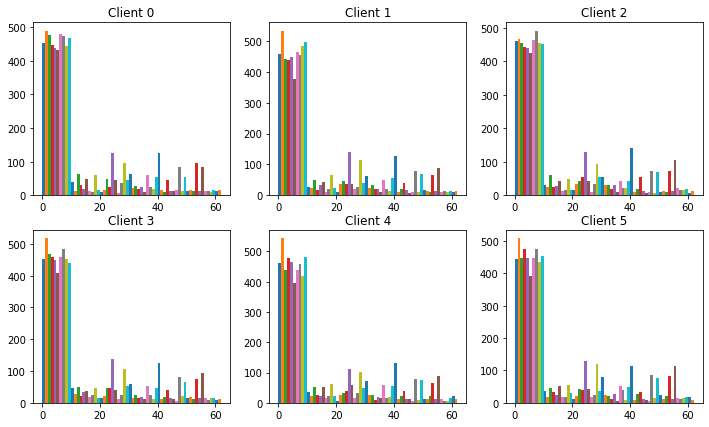

In [25]:
f = plt.figure(figsize=(12,7))
for i in range(6):
  client_dataset = clients[i].Train_dataset
  plot_data = collections.defaultdict(list)
  for label in client_dataset[1]:
    plot_data[label].append(label)
  plt.subplot(2,3,i+1)
  plt.title('Client {}'.format(i))
  for j in range(62):
    plt.hist(
        plot_data[j],
        density = False,
        bins = [x for x in range(63)]
    )

Distance Between two models

In [82]:
def Distance(HookModel,TestModel):
  len_it = len(HookModel.trainable_variables)
  Hook_weights=[]
  Test_weights=[]
  for index in range(len_it):
    Hook_weights.append(HookModel.trainable_variables[index].numpy())
    Test_weights.append(TestModel.trainable_variables[index].numpy())
  target = []
  dis_norm2=[]
  for i in range(len_it):
    target.append(Hook_weights[i]-Test_weights[i])
    dis_norm2.append(np.linalg.norm(target[i],2))
  weight_weights = np.ones([len_it,1])
  #调整权重
  weight_weights[0]=0
  weight_weights[1]=0
  dis = np.dot(dis_norm2,weight_weights)
  return dis
  # return dis_norm2

In [55]:
def BetterNode(clients,model,Total_NUM,FedAvg_NUM):
  NodeDict=collections.OrderedDict()
  for i in range(Total_NUM):
    NodeDict[i] = Distance(model,clients[i].model)
  Dlst = sorted(NodeDict.items(),key=lambda x:x[1])
  NodeList = []
  for i in range(FedAvg_NUM):
    NodeList.append(Dlst[i][0])
  return NodeList

# 阶段三：Clients 训练节点数据并聚合


In [106]:
def FedAvg(NUM_CLIENTS,model,FedAvg_NUM=7):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  FedNodeList=BetterNode(clients,iterModel,NUM_CLIENTS,FedAvg_NUM)
  print("FedAvg Node is",FedNodeList)
  Cut=2
  for c in range(Cut):
    # tmp =np.array(iterModel.trainable_variables[c].numpy(),dtype='float64')
    all_weights.append(iterModel.trainable_variables[c].numpy())

  for weights_index in range(Cut,len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in FedNodeList:
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/FedAvg_NUM)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [86]:
NUM_EPOCHS = 10

In [111]:
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  FedModel = FedAvg(NUM_CLIENTS,SendModel)
  S.PreEval(FedModel,x_test,y_test)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
200/200 [==============================] - 1s 2ms/step - loss: 22.0345 - accuracy: 0.5218
FedAvg Node is [2, 0, 6, 3, 7, 1, 8]
313/313 [==============================] - 1s 1ms/step - loss: 0.6173 - accuracy: 0.8436
EPOCHS 1 is starting...
200/200 [==============================] - 1s 2ms/step - loss: 21.3730 - accuracy: 0.5096
FedAvg Node is [2, 7, 0, 3, 8, 6, 5]
313/313 [==============================] - 1s 1ms/step - loss: 0.6856 - accuracy: 0.8495
EPOCHS 2 is starting...
200/200 [==============================] - 1s 3ms/step - loss: 18.2543 - accuracy: 0.5233
FedAvg Node is [2, 7, 8, 9, 0, 5, 6]
313/313 [==============================] - 1s 2ms/step - loss: 0.7270 - accuracy: 0.8521
EPOCHS 3 is starting...
200/200 [==============================] - 1s 2ms/step - loss: 18.2555 - accuracy: 0.5211
FedAvg Node is [4, 9, 0, 5, 2, 1, 3]
313/313 [==============================] - 1s 1ms/step - loss: 0.7665 - accuracy: 0.8491
EPOCHS 4 is starting...
200/200 [=======

## 节点训练
OK！fine,我这两天就是为了实现一个循环。。。
真他娘的丢人

In [ ]:
for i in range(NUM_CLIENTS):
  clients[i].ReceiveModel(a.copy())
  clients[i].NodeTrain()

In [ ]:
for i in range(NUM_CLIENTS):
  print("Node {} is evaluating...".format(i))
  clients[i].NodeEval()
  ##虽然这个步骤没啥用

Node 0 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3676 - accuracy: 0.9269
Node 1 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3695 - accuracy: 0.9273
Node 2 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.5132 - accuracy: 0.9271
Node 3 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3902 - accuracy: 0.9242
Node 4 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.4435 - accuracy: 0.9231
Node 5 is evaluating...
313/313 [==============================] - 1s 1ms/step - loss: 0.3814 - accuracy: 0.9300
Node 6 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3722 - accuracy: 0.9262
Node 7 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.3679 - accuracy: 0.9250
Node 8 is evaluating...
313/313 [==============================] - 0s 1ms/step - loss: 0.4051 - 

In [ ]:
def DiffModel(model1,model2,layer_name,w_vs_b=0):
  l1 = model1.get_layer(layer_name).get_weights()[w_vs_b].reshape([-1,])
  l2 = model2.get_layer(layer_name).get_weights()[w_vs_b].reshape([-1,])
  # l1 = model1.trainable_variables
  # l2 = model2.trainable_variables
  # print(l1)
  l1.shape
  # l1 = l1.reshape([-1,])
  # l2 = l2.reshape([-1,])
  for i in range(len(l1)):
    if l1[i]!=l2[i]:
      print("NOT SAME MODEL")
      return

In [ ]:
DiffModel(clients[0].model,clients[1].model,'dense_1')

NOT SAME MODEL


## 模型聚合 FedAvg
THIS IS THE MOST IMPORANT！

In [ ]:
##先实现普通聚合，再考虑距离问题

In [ ]:
# clients[0].Train_dataset[0].shape

(60000, 28, 28)

In [ ]:
# a_1 = a.trainable_variables
# b_1 = clients[0].model.trainable_variables
# for _a,_b in zip(a_1,b_1):
#   # print(_a,_b,'\n')
#   print(type(_a))

<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>
<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>
<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>
<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>


In [ ]:
# tmp = a_1[0]
# tmp2 = b_1[0]

In [ ]:
# print(tmp.name)
# print(tmp2.name)

fl_model_57/dense_1/kernel:0
fl_model_60/dense_1/kernel:0


In [ ]:
# tmp.numpy()

array([[-0.07970653,  0.07991762,  0.05910995, ...,  0.0579403 ,
         0.0321511 ,  0.02421231],
       [-0.05695383,  0.03625515, -0.06860252, ...,  0.02591816,
         0.04554088,  0.02055327],
       [-0.01783558, -0.04462572, -0.02057564, ...,  0.02187481,
        -0.04054561, -0.02853347],
       ...,
       [-0.05783828, -0.05880497,  0.07976013, ..., -0.03510847,
        -0.03695404,  0.03616227],
       [-0.06651882,  0.02818294, -0.02726433, ..., -0.05769905,
        -0.04426115, -0.00901749],
       [-0.01624558,  0.05673347, -0.07569796, ..., -0.05263541,
        -0.0753431 , -0.04903179]], dtype=float32)

In [ ]:
# tmp.numpy().shape

(784, 128)

In [ ]:
#  tmp2 =np.zeros(a.trainable_variables[0].numpy().shape,dtype='float64')

In [ ]:
# tmp2.shape

(784, 128)

In [ ]:
#聚合先不考虑权重
def FedAvg(NUM_CLIENTS):
  iterModel = a.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [ ]:
fedmodel = FedAvg(10)

In [ ]:
#昨天留的任务是如何把聚合后的numpy数组，转到模型中

In [ ]:
S.PreEval(fedmodel,x_test,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 7.8235 - accuracy: 0.2031


In [ ]:
len(fed)

4